# Missing values experiments (Figures 2 and 3)

# Importing libraries

Parts of this notebook come from the MIWAE paper's supplementary material (https://github.com/pamattei/miwae).

In [2]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import torch.distributions as td

import seaborn as sns
import datetime as dt
from tqdm import tqdm

from time import time
from hyperimpute.plugins.imputers import Imputers

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.rcParams.update(tex_fonts)

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.impute import SimpleImputer

from source.auxiliary_functions import remove_outliers_DDC, apply_estimator, contaminate_bernoulli, low_rank

In [3]:
def mse(xhat,xtrue,mask): # MSE function for imputations
    xhat = np.array(xhat)
    xtrue = np.array(xtrue)
    return np.mean(np.power(xhat-xtrue,2)[~mask])

# Generating synthetic dataset

In [31]:
NREP = 5
N = 20
n=100
p = 500
effective_rank = 5

epsilons = np.linspace(0.0001, 0.8, N)

h = 128 # number of hidden units in (same for all MLPs)
d = 1 # dimension of the latent space
K = 20 # number of IS during training

In [32]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

# MIWAE implementation as in https://github.com/pamattei/miwae

### Model building

We will use a **deep latent variable model with a Gaussian prior and a Student's t observation model**. This can be written:

$$p(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p(\mathbf{x}_i|\mathbf{z}_i) = \text{St} (\mathbf{x}_i|\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}_i),\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}_i),\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\mu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}^p$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$ are functions parametrised by deep neural nets.

The weights of these nets are stored in a parameter $\boldsymbol{\theta}$. We choose to use the following simple architecture, where the 3 neural nets share the first layers:
$$f_{\boldsymbol{\theta}} (\mathbf{z})=\sigma(\mathbf{W}_1\sigma(\mathbf{W}_0\mathbf{z}+\mathbf{b}_0)+\mathbf{b}_1) $$

$$\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}) = \mathbf{W}_\boldsymbol{\mu}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\mu}, $$

$$\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}) = \text{Diag}\left(\text{Softplus}(\mathbf{W}_\boldsymbol{\sigma}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\sigma}) + 10^{-3}\right), $$

$$\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z}) = \text{Softplus}(\mathbf{W}_\boldsymbol{\nu}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\nu}) + 3. $$

A few **non-essential remarks** about this architecture:

* This parametrisation is quite close to the one we use in the MIWAE paper. The main difference is that we use $\sigma = \text{ReLU}$ (which leads to faster training) while we used $\sigma = \text{tanh}$ in the paper.
*   We use a [location-scale parametrisation](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family) of the t distribution, following [the parametrisation available in TensorFlow](https://www.tensorflow.org/api_docs/python/tf/distributions/StudentT). Note in particular that $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$ is not the covariance matrix of $\mathbf{x} | \mathbf{z}$. When it exitsts, the actual covariance matrix is diagonal with diagonal  $$ \frac{\text{diag}(\boldsymbol{\Sigma}_{\boldsymbol{\theta}} (\mathbf{z}))^2 \boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z})}{\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z})-2}$$ (where all operations are made entrywise).
*   The fact that the covariance matrix is diagonal means that we assume that **the features are independent conditionnally on the latent variable** (which is customary for DLVMs).
* We add $3$ to the neural net that outputs the degrees of freedom. This is to guarantee that the tails of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ are not too heavy. Indeed, having too heavy tails might imply that the mean of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ does not exist! Adding 3 implies that the degrees of freedom is always larger than 3, implying in turn that **at least the first 3 moments of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ are well-defined.**
* We add $10^{-3}$ to the diagonal entries of $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}$ to prevent singularities, [as advocated in our NeurIPS 2018 paper](https://papers.nips.cc/paper/7642-leveraging-the-exact-likelihood-of-deep-latent-variable-models). Why $10^{-3}$ specifically? Because, since the data have unit variance, this will imply that the latent variable explains at most $99.9999\%$ of the variance of the data, which does not seem too restrictive. **This choice might be poor if the data are not standardised.**




We begin with the prior:

In [33]:
p_z = td.Independent(td.Normal(loc=torch.zeros(d).to(DEVICE),scale=torch.ones(d).to(DEVICE)),1)

 Now, we define the **decoder**, which will be the backbone of the three functions $\boldsymbol{\mu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}^p$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$. Here, the output space of this decoder is $\mathbb{R}^{3p}$. Some additional operations are needed for $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$, but it'll be more convenient to implement them later.

### Posterior approximation

We will build a Gaussian posterior approximation $q(\mathbf{z}|\mathbf{x}) = \mathcal{N} (\mathbf{z}|\mathbf{m}_\gamma (\mathbf{x}),\mathbf{S}_\gamma (\mathbf{x}))$ by using an **encoder** that mimicks the architecture of the decoder.

### Building the MIWAE loss

We will define a function that, given the imputation $\iota(\mathbf{x}^\text{o})$ and the mask, computes the MIWAE bound.

$$
\mathcal{L}_K (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z}_{i1},\ldots,\mathbf{z}_{iK} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}^\text{o}_i)} \left[ \log\frac{1}{K} \sum_{k=1}^K \frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i^\text{o}|\mathbf{z}_{ik})p(\mathbf{z}_{ik})}{q_{\boldsymbol{\gamma}}(\mathbf{z}_{ik}|\mathbf{x}^\text{o}_i)} \right].
$$

In [34]:
def miwae_loss(iota_x,mask, encoder, decoder):
    batch_size = iota_x.shape[0]
    out_encoder = encoder(iota_x)
    q_zgivenxobs = td.Independent(td.Normal(loc=out_encoder[..., :d],scale=torch.nn.Softplus()(out_encoder[..., d:(2*d)])),1)
  
    zgivenx = q_zgivenxobs.rsample([K])
    zgivenx_flat = zgivenx.reshape([K*batch_size,d])
  
    out_decoder = decoder(zgivenx_flat)
    all_means_obs_model = out_decoder[..., :p]
    all_scales_obs_model = torch.nn.Softplus()(out_decoder[..., p:(2*p)]) + 0.001
    all_degfreedom_obs_model = torch.nn.Softplus()(out_decoder[..., (2*p):(3*p)]) + 3
  
    data_flat = torch.Tensor.repeat(iota_x,[K,1]).reshape([-1,1])
    tiledmask = torch.Tensor.repeat(mask,[K,1])
  
    all_log_pxgivenz_flat = torch.distributions.StudentT(loc=all_means_obs_model.reshape([-1,1]),scale=all_scales_obs_model.reshape([-1,1]),df=all_degfreedom_obs_model.reshape([-1,1])).log_prob(data_flat)
    all_log_pxgivenz = all_log_pxgivenz_flat.reshape([K*batch_size,p])
   
    logpxobsgivenz = torch.sum(all_log_pxgivenz*tiledmask,1).reshape([K,batch_size])
    logpz = p_z.log_prob(zgivenx)
    logq = q_zgivenxobs.log_prob(zgivenx)
  
    neg_bound = -torch.mean(torch.logsumexp(logpxobsgivenz + logpz - logq,0))
  
    return neg_bound

### Single imputation

We can do single imputation using self normalised IS:
\begin{equation*}
\mathbb E [\mathbf{x}^{\textrm{m}} | \mathbf{x}^{\textrm{o}}] \approx \sum_{l=1}^L w_l \, \mathbf{x}^{\textrm{m}}_{(l)},
\end{equation*}
where $(\mathbf{x}^{\textrm{m}}_{(1)},\mathbf{z}_{(1)}),\ldots,(\mathbf{x}^{\textrm{m}}_{(L)},\mathbf{z}_{(L)})$ are i.i.d.~samples from $p_{\boldsymbol{\theta}}(\mathbf{x}^{\textrm{m}}|\mathbf{x}^{\textrm{o}},\mathbf{z})q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}^{\textrm{o}})$ and 
\begin{equation*}
w_l=\frac{r_l}{r_1+\ldots+r_L}, \; \textrm{with} \; r_l = \frac{p_{\boldsymbol{\theta}}(\mathbf{x}^{\textrm{o}}|\mathbf{z}_{(l)})p(\mathbf{z}_{(l)})}{q_{\boldsymbol{\gamma}}(\mathbf{z}_{(l)}|\mathbf{x}^{\textrm{o}})}.
\end{equation*}

In [35]:
def miwae_impute(iota_x,mask,L, encoder, decoder):
    batch_size = iota_x.shape[0]
    out_encoder = encoder(iota_x)
    q_zgivenxobs = td.Independent(td.Normal(loc=out_encoder[..., :d],scale=torch.nn.Softplus()(out_encoder[..., d:(2*d)])),1)
  
    zgivenx = q_zgivenxobs.rsample([L])
    zgivenx_flat = zgivenx.reshape([L*batch_size,d])
   
    out_decoder = decoder(zgivenx_flat)
    all_means_obs_model = out_decoder[..., :p]
    all_scales_obs_model = torch.nn.Softplus()(out_decoder[..., p:(2*p)]) + 0.001
    all_degfreedom_obs_model = torch.nn.Softplus()(out_decoder[..., (2*p):(3*p)]) + 3
  
    data_flat = torch.Tensor.repeat(iota_x,[L,1]).reshape([-1,1]).to(DEVICE)
    tiledmask = torch.Tensor.repeat(mask,[L,1]).to(DEVICE)
  
    all_log_pxgivenz_flat = torch.distributions.StudentT(loc=all_means_obs_model.reshape([-1,1]),scale=all_scales_obs_model.reshape([-1,1]),df=all_degfreedom_obs_model.reshape([-1,1])).log_prob(data_flat)
    all_log_pxgivenz = all_log_pxgivenz_flat.reshape([L*batch_size,p])
    
    logpxobsgivenz = torch.sum(all_log_pxgivenz*tiledmask,1).reshape([L,batch_size])
    logpz = p_z.log_prob(zgivenx)
    logq = q_zgivenxobs.log_prob(zgivenx)
  
    xgivenz = td.Independent(td.StudentT(loc=all_means_obs_model, scale=all_scales_obs_model, df=all_degfreedom_obs_model),1)

    imp_weights = torch.nn.functional.softmax(logpxobsgivenz + logpz - logq,0) # these are w_1,....,w_L for all observations in the batch
    xms = xgivenz.sample().reshape([L,batch_size,p])
    xm=torch.einsum('ki,kij->ij', imp_weights, xms) 

    return xm

### Training

In [36]:
def weights_init(layer):
    if type(layer) == nn.Linear: torch.nn.init.orthogonal_(layer.weight)

In [37]:
def MIWAE_estimate(X, mask, n_epochs=502, bs=64):
    miwae_loss_train=np.array([])
    mse_train=np.array([])
    mse_train2=np.array([])
    
    xhat = np.copy(X) # This will be out imputed data matrix
    
    decoder = nn.Sequential(
        torch.nn.Linear(d, h),
        torch.nn.ReLU(),
        torch.nn.Linear(h, h),
        torch.nn.ReLU(),
        torch.nn.Linear(h, 3*p),  # the decoder will output both the mean, the scale, and the number of degrees of freedoms (hence the 3*p)
    )
    
    encoder = nn.Sequential(
        torch.nn.Linear(p, h),
        torch.nn.ReLU(),
        torch.nn.Linear(h, h),
        torch.nn.ReLU(),
        torch.nn.Linear(h, 2*d),  # the encoder will output both the mean and the diagonal covariance
    )
    
    encoder.to(DEVICE) # we'll use the GPU
    decoder.to(DEVICE)

    encoder.apply(weights_init)
    decoder.apply(weights_init)
    
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=1e-3)

    for ep in range(1,n_epochs):
        perm = np.random.permutation(n) # We use the "random reshuffling" version of SGD
        batches_data = np.array_split(xhat[perm,], n/bs)
        batches_mask = np.array_split(mask[perm,], n/bs)
        for it in range(len(batches_data)):
            optimizer.zero_grad()
            encoder.zero_grad()
            decoder.zero_grad()
            b_data = torch.from_numpy(batches_data[it]).float().to(DEVICE)
            b_mask = torch.from_numpy(batches_mask[it]).float().to(DEVICE)
            loss = miwae_loss(iota_x = b_data,mask = b_mask, encoder=encoder, decoder=decoder)
            loss.backward()
            optimizer.step()
        #if ep % 100 == 1:
        #    print('Epoch %g' %ep)
        #    print('MIWAE likelihood bound  %g' %(-np.log(K)-miwae_loss(iota_x = torch.from_numpy(X).float().to(DEVICE),\
        #                                                               mask = torch.from_numpy(mask).float().to(DEVICE),\
        #                                                               encoder = encoder, decoder = decoder\
        #                                                              ).cpu().data.numpy()
        #                                        )\
        #         ) # Gradient step       
    result = miwae_impute(iota_x=torch.from_numpy(X).float().to(DEVICE),\
                          mask = torch.from_numpy(mask).float().to(DEVICE),\
                          L=10,\
                          encoder=encoder, decoder=decoder).cpu().data.numpy()
    del optimizer
    del encoder
    del decoder
    
    return result   

# Plotting the figures

In [38]:
classical_error = np.zeros((N,NREP))
mean_error = np.zeros((N,NREP))
median_error = np.zeros((N,NREP))
MI_1_error = np.zeros((N,NREP))
MI_time = np.zeros((N, NREP))
knn_error = np.zeros((N,NREP))
knn_time = np.zeros((N,NREP))
miwae_error = np.zeros((N,NREP))
miwae_time = np.zeros((N,NREP))
gain_error = np.zeros((N,NREP))
gain_time = np.zeros((N,NREP))
MV_error = np.zeros((N,NREP))
MV_time = np.zeros((N, NREP))


for k in tqdm(range(NREP)):
    
    np.random.seed(k)
    
    C_true,_ = low_rank(effective_rank, p)
    data = np.random.multivariate_normal(np.zeros(p), C_true, size=n)
    true_norm = np.linalg.norm(C_true, ord=2)
    
    for i, eps in enumerate(epsilons):
        
        missing_data, mask = contaminate_bernoulli(data, eps, intensity=0, option='dirac')
        classical_error[i,k] = np.linalg.norm(np.cov(missing_data.T) - C_true, ord=2)/true_norm
        
        missing_data[missing_data == 0] = np.nan
        
        #2. mean and median imputation
        mean_data = np.zeros(data.shape)
        med_data = np.zeros(data.shape)
        for dim in range(data.shape[1]):
            marginal = missing_data[:, dim]
            m = np.mean(marginal[~np.isnan(marginal)])
            M = np.median(marginal[~np.isnan(marginal)])

            mean_marginal = marginal.copy()
            mean_marginal[np.isnan(marginal)] = m
            mean_data[:, dim] = mean_marginal

            med_marginal = marginal.copy()
            med_marginal[np.isnan(marginal)] = M
            med_data[:, dim] = med_marginal

        C_mean = np.cov(mean_data.T)
        C_med = np.cov(med_data.T)
        
        mean_error[i,k] = np.linalg.norm(C_mean - C_true, ord=2)/true_norm
        median_error[i,k] = np.linalg.norm(C_med- C_true, ord=2)/true_norm

        #3. multiple imputation (inspired by MICE)
        tstart = time()
        imputer = IterativeImputer(max_iter=10, random_state=0)
        MI_data = imputer.fit_transform(missing_data)
        tend = time()
        C_MI_1 = np.cov(MI_data.T)
        MI_1_error[i,k] = np.linalg.norm(C_MI_1 - C_true, ord=2)/true_norm
        MI_time[i,k] = tend - tstart

        #4. knnimpute
        tstart = time()
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        knn_data = imputer.fit_transform(missing_data)  
        C_knn = np.cov(knn_data.T)
        tend = time()
        knn_error[i,k] = np.linalg.norm(C_knn - C_true, ord=2)/true_norm
        knn_time[i,k] = tend - tstart
        
        #5. MIWAE
        tstart = time()
        missing_data_0 = np.copy(missing_data)
        missing_data_0[np.isnan(missing_data)] = 0
        X_MIWAE = MIWAE_estimate(missing_data_0, 1-mask, n_epochs=502, bs=32)
        miwae_data = (1-mask)*data + mask*X_MIWAE
        C_MIWAE = np.cov(miwae_data.T)
        tend = time()
        miwae_error[i,k] = np.linalg.norm(C_MIWAE - C_true, ord=2)/true_norm
        miwae_time[i,k] = tend - tstart
        
        #5. GAIN
        tstart = time()
        gain = Imputers().get('gain')
        x_gain = gain.fit_transform(missing_data)
        C_GAIN = np.cov(x_gain.T)
        tend = time()
        gain_error[i,k] = np.linalg.norm(C_GAIN - C_true, ord=2)/true_norm
        gain_time[i,k] = tend - tstart
        
        #4. MVestimator
        tstart = time()
        mask = (np.isnan(missing_data)).astype(int)
        C_MV, _ = apply_estimator('oracleMV', missing_data, mask=mask)
        tend = time()
        MV_error[i,k] = np.linalg.norm(C_MV - C_true, ord=2)/true_norm
        MV_time[i,k] = tend - tstart

  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/.local/lib/python3.9/site-pac

/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impu

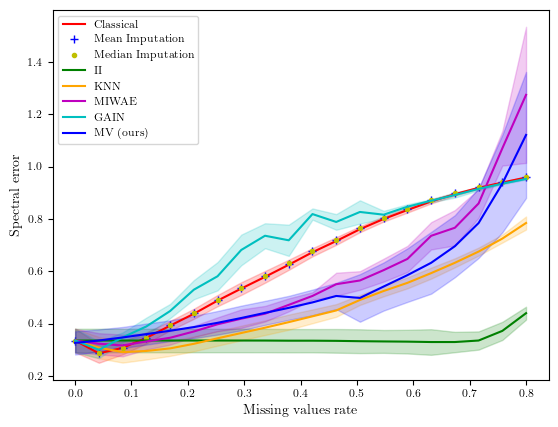

In [39]:
plt.plot(epsilons, classical_error.mean(axis=-1), label='Classical', color='r')
plt.fill_between(epsilons, classical_error.mean(axis=-1) - classical_error.std(axis=-1), classical_error.mean(axis=-1) + classical_error.std(axis=-1), color='r', alpha=0.2)
plt.plot(epsilons, mean_error.mean(axis=-1),'+b', label='Mean Imputation')
plt.plot(epsilons, median_error.mean(axis=-1), '.y', label='Median Imputation')
plt.plot(epsilons, MI_1_error.mean(axis=-1), label='II', color='g')
plt.fill_between(epsilons, MI_1_error.mean(axis=-1) - MI_1_error.std(axis=-1), MI_1_error.mean(axis=-1) + MI_1_error.std(axis=-1), color='g', alpha=0.2)
plt.plot(epsilons, knn_error.mean(axis=-1), label='KNN', color='orange')
plt.fill_between(epsilons, knn_error.mean(axis=-1) - knn_error.std(axis=-1), knn_error.mean(axis=-1) + knn_error.std(axis=-1), color='orange', alpha=0.2)
plt.plot(epsilons, miwae_error.mean(axis=-1),'-m', label='MIWAE')
plt.fill_between(epsilons, miwae_error.mean(axis=-1) - miwae_error.std(axis=-1), miwae_error.mean(axis=-1) + miwae_error.std(axis=-1), color='m', alpha=0.2)
plt.plot(epsilons, gain_error.mean(axis=-1),'-c', label='GAIN')
plt.fill_between(epsilons, gain_error.mean(axis=-1) - gain_error.std(axis=-1), gain_error.mean(axis=-1) + gain_error.std(axis=-1), color='c', alpha=0.2)
plt.plot(epsilons, MV_error.mean(axis=-1), label='MV (ours)', color='b')
plt.fill_between(epsilons, MV_error.mean(axis=-1) - MV_error.std(axis=-1), MV_error.mean(axis=-1) + MV_error.std(axis=-1), color='b', alpha=0.2)
plt.legend()
plt.xlabel('Missing values rate')
plt.ylabel('Spectral error')
plt.savefig("synthetic_missing_data_500_n100+MIWAE.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [12]:
print(knn_time.mean(), knn_time.std())
print(MI_time.mean(), MI_time.std())
print(MV_time.mean(), MV_time.std())
print(miwae_time.mean(), miwae_time.std())
print(gain_time.mean(), gain_time.std())

0.046223297119140624 0.017149837193705657
12.857139630317688 4.548925703661686
0.0005930519104003906 7.083874847767283e-05
67.06540761470795 0.5598140483105013
10.744254736900329 0.2504301816372997


# Exercise:

In [34]:
from hyperimpute.plugins.imputers import Imputers
from source.real_experiment import rel_dist

def test_estimators(data, nrep):
    print("dim : ", data.shape[1])
    print("nsamples : ", data.shape[0])
    truth = np.cov(data.T)
    
    C = {}
    
    C['classical'] = np.zeros((nrep, data.shape[1], data.shape[1]))
    C['DDC MV 99'] = np.zeros((nrep, data.shape[1], data.shape[1]))
    C['DDC MV 95'] = np.zeros((nrep, data.shape[1], data.shape[1]))
    C['DDC II'] = np.zeros((nrep, data.shape[1], data.shape[1]))
    C['DDC KNN'] = np.zeros((nrep, data.shape[1], data.shape[1]))
    C['DDC MIWAE'] = np.zeros((nrep, data.shape[1], data.shape[1]))
    C['DDC GAIN'] = np.zeros((nrep, data.shape[1], data.shape[1]))
    C['TSGS'] = np.zeros((nrep, data.shape[1], data.shape[1]))
    C['DI'] = np.zeros((nrep, data.shape[1], data.shape[1]))

    for k in tqdm(range(nrep)):
            
        np.random.seed(k)
        
        conta_data, mask = contaminate_bernoulli(data, 0.05, intensity=4, option='dirac')
    
        ddc_mask_99, _ = remove_outliers_DDC(conta_data)
        ddc_mask_95, _ = remove_outliers_DDC(conta_data, 0.95)
        
        data_nan = conta_data*ddc_mask_99
        data_nan[data_nan == 0] = np.nan
        
        C['classical'][k] = np.cov(conta_data.T)
        
        # DDC 99
        C['DDC MV 99'][k], _ = apply_estimator('oracleMV', conta_data, 1-ddc_mask_99)
        C['DDC MV 95'][k], _ = apply_estimator('oracleMV', conta_data, 1-ddc_mask_95)
        
        
        C['DDC II'][k], _ = apply_estimator('DDCII', conta_data)
        C['DDC KNN'][k], _ = apply_estimator('DDCKNN', conta_data)
        C['TSGS'][k], _ = apply_estimator('TSGS', conta_data)
        C['DI'][k], _ = apply_estimator('DI', conta_data)

        # GAIN
        gain = Imputers().get('gain')

        x_gain = gain.fit_transform(data_nan)
        C['DDC GAIN'][k] = np.cov(x_gain.T)
        
        # MIWAE
        miwae = Imputers().get('miwae')

        x_miwae = miwae.fit_transform(data_nan)
        C['DDC MIWAE'][k] = np.cov(x_miwae.T)
        

    cols = ['classical','DDC MV 99','DDC MV 95', 'DDC II', 'DDC KNN', 'DDC MIWAE','DDC GAIN', 'TSGS', 'DI']
    index = ['Truth','classical','DDC MV 99','DDC MV 95', 'DDC II', 'DDC KNN', 'DDC MIWAE','DDC GAIN', 'TSGS']
    results = pd.DataFrame('-', columns=cols,
                                index=index)
    stds = pd.DataFrame('-', columns=cols,
                                index=index)   
    
    for c in cols:
        results.loc['Truth',c] = np.mean([rel_dist(truth, C[c][k]) for k in range(nrep)])*100
        stds.loc['Truth',c] = np.std([rel_dist(truth, C[c][k]) for k in range(nrep)])*100

    for i,c1 in enumerate(cols[:-1]):
        for c2 in cols[i+1:]:
            results.loc[c1, c2] = np.mean([rel_dist(C[c1][k], C[c2][k]) for k in range(nrep)])*100
            stds.loc[c1, c2] = np.std([rel_dist(C[c1][k], C[c2][k]) for k in range(nrep)])*100

    return results, stds

In [35]:
from source.real_experiment import clean_abalone

data = pd.read_csv('datasets/abalone.data', sep=',', header=None)
data, _ = clean_abalone()

A,B = test_estimators(data, 25)

dim :  7
nsamples :  4173


  0%|                                                                                                                                                                                | 0/25 [00:00<?, ?it/s]/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
  4%|██████▋                                                                                                                                                                 | 1/25 [01:15<30:14, 75.62s/it]/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
  8%|█████████████▍                                                                                                                                                          | 2/25 [02:31<29:08, 76.02s/it]/Users/gregoirep

,classical,DDC MV 99,DDC MV 95,DDC II,DDC KNN,DDC MIWAE,DDC GAIN,TSGS,DI
Truth,12.806215,4.118636,6.80708,1.700153,2.063667,3.461433,5.058628,3.06374,8.84598
classical,-,13.081589,14.347056,12.989468,13.02363,12.942237,13.051014,13.444983,14.924186
DDC MV 99,-,-,2.985736,2.515526,2.224092,1.871959,2.655402,5.435354,8.78715
DDC MV 95,-,-,-,5.272252,5.029256,4.04052,3.705046,8.279789,9.985468
DDC II,-,-,-,-,0.464906,1.882454,3.488529,3.269416,8.278658
DDC KNN,-,-,-,-,-,1.582015,3.189816,3.455419,8.147393
DDC MIWAE,-,-,-,-,-,-,1.702198,4.504044,7.2202
DDC GAIN,-,-,-,-,-,-,-,5.966922,6.705041
TSGS,-,-,-,-,-,-,-,-,6.935405


In [ ]:
A

In [36]:
B

,classical,DDC MV 99,DDC MV 95,DDC II,DDC KNN,DDC MIWAE,DDC GAIN,TSGS,DI
Truth,0.45049,0.28515,0.257867,0.102986,0.092195,0.179093,0.349138,0.206231,1.484444
classical,-,0.446522,0.391287,0.419928,0.41893,0.425483,0.428416,0.496232,0.781689
DDC MV 99,-,-,0.14639,0.258252,0.253603,0.222727,0.349304,0.345832,1.082874
DDC MV 95,-,-,-,0.257824,0.25867,0.207891,0.235709,0.361365,0.995389
DDC II,-,-,-,-,0.054715,0.171716,0.335299,0.132703,1.368663
DDC KNN,-,-,-,-,-,0.173893,0.332272,0.204064,1.353119
DDC MIWAE,-,-,-,-,-,-,0.32033,0.312243,1.193101
DDC GAIN,-,-,-,-,-,-,-,0.366787,1.026199
TSGS,-,-,-,-,-,-,-,-,1.805015


In [37]:
from source.real_experiment import clean_breast_cancer

data, _ = clean_breast_cancer()

A,B = test_estimators(data, 25)

dim :  30
nsamples :  569


  0%|                                                                                                                                                                                | 0/25 [00:00<?, ?it/s]/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
  4%|██████▋                                                                                                                                                                 | 1/25 [00:49<19:42, 49.28s/it]/Users/gregoirepacreau/.local/lib/python3.9/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
  8%|█████████████▍                                                                                                                                                          | 2/25 [01:38<18:58, 49.52s/it]/Users/gregoirep

In [38]:
A

,classical,DDC MV 99,DDC MV 95,DDC II,DDC KNN,DDC MIWAE,DDC GAIN,TSGS,DI
Truth,10.227118,45.709632,47.76989,36.62723,39.948524,56.497568,43.969377,41.973667,17.219576
classical,-,45.239389,47.265275,36.557182,39.607144,55.767643,43.459239,41.097205,19.872593
DDC MV 99,-,-,4.923363,17.098653,10.162266,20.704477,6.654292,11.337941,39.615315
DDC MV 95,-,-,-,20.304129,14.031729,18.39532,9.856508,14.763815,42.075994
DDC II,-,-,-,-,10.289666,32.840815,14.006202,15.519238,30.405045
DDC KNN,-,-,-,-,-,27.73204,7.533418,9.071665,33.013264
DDC MIWAE,-,-,-,-,-,-,22.847322,25.70627,51.819024
DDC GAIN,-,-,-,-,-,-,-,8.22987,37.852957
TSGS,-,-,-,-,-,-,-,-,35.782588


In [39]:
B

,classical,DDC MV 99,DDC MV 95,DDC II,DDC KNN,DDC MIWAE,DDC GAIN,TSGS,DI
Truth,0.50621,0.515702,0.4083,0.624924,0.442952,0.512063,0.869146,0.880586,1.819573
classical,-,0.967116,0.873955,1.040727,1.008275,0.891122,1.205712,1.33319,1.818757
DDC MV 99,-,-,0.433006,0.82018,0.538566,0.378822,0.55289,1.009528,2.100137
DDC MV 95,-,-,-,0.812566,0.511543,0.605987,0.899957,0.920517,2.026863
DDC II,-,-,-,-,0.504834,0.677858,0.957954,1.405881,2.458618
DDC KNN,-,-,-,-,-,0.463393,1.312594,1.39689,2.40707
DDC MIWAE,-,-,-,-,-,-,1.28431,1.394811,1.771957
DDC GAIN,-,-,-,-,-,-,-,1.104889,2.332156
TSGS,-,-,-,-,-,-,-,-,2.400217
